# 1. Setup and Library Installation

In this section, we install the necessary libraries (fastbook, waterfallcharts, treeinterpreter, dtreeviz) and import key modules for tabular data analysis and machine learning.

In [ ]:
#hide
! pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# 2. Data Loading and Preprocessing

Here, we load the dataset, parse dates, and define our dependent variable (`5m_forward_returns`). We also set up the `TabularPandas` object from the `fastai` library, which handles splitting the data into training and validation sets (based on time) and preprocessing steps like filling missing values and categorifying variables.

In [ ]:
df = pd.read_csv("data/data.csv",
                 low_memory=False,
                 parse_dates=["timestamp", "minute_utc"],
                 )
df["minute_utc"] = pd.to_datetime(df["minute_utc"], utc=True, errors="coerce")

In [ ]:
df.columns

Index(['timestamp', 'bid_open', 'bid_high', 'bid_low', 'bid_close', 'volume',
       'minute_utc', 'eur_story_count', 'usd_story_count', 'eur_w_sum',
       'usd_w_sum', 'eur_score_wavg', 'usd_score_wavg', 'eur_score_wstd',
       'usd_score_wstd', 'eur_minus_usd_score_wavg', 'shared_story_count',
       'shared_w_sum', 'shared_score_wavg', 'shared_score_wstd', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_6', 'segment_id', 'RSI',
       'RSI_fast', 'RSI_slow', 'MFI', 'STOCH', 'ADX', 'AROON', 'ADOSC',
       'stretch', '%B', 'bandwidth', 'stretch_5', '%B_5', 'bandwidth_5',
       'MACD_hist', 'Dir_Ind_Diff', 'BOP', 'delta_BOP', 'smoothed_BOP',
       'delta_sm_BOP', 'MOM_1', 'MOM_3', 'MOM_5', 'MOM_10', 'VWAP_res',
       'KAMA_res', 'cos_time_cycle', 'sin_time_cycle', 'realized_vol',
       'realized_vol_60', 'relative_volume', 'bid_range', 'ADOSC_lag_1',
       'ADOSC_lag_2', 'ADOSC_lag_3', 'AROON_lag_1', 'AROON_lag_2',
       'AROON_lag_3', 'RSI_lag_1', 'RSI_lag_2', 'RSI_l

In [ ]:
dep_var = "5m_forward_returns"

In [ ]:
procs = [FillMissing]

In [ ]:
cond1 = (df.index < 58960) & df['5m_forward_returns'].notna()
cond2 = (df.index > 58964) & df['5m_forward_returns'].notna()
train_idx = np.where(cond1)[0]
valid_idx = np.where(cond2)[0]

splits = (list(train_idx), list(valid_idx))

In [ ]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

/usr/local/lib/python3.12/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/usr/local/lib/python3.12/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [ ]:
len(to.train), len(to.valid)

(58960, 11970)

In [ ]:
to.show(5)

,timestamp,minute_utc,eur_score_wavg_na,usd_score_wavg_na,eur_score_wstd_na,usd_score_wstd_na,eur_minus_usd_score_wavg_na,shared_score_wavg_na,shared_score_wstd_na,bid_open,bid_high,bid_low,bid_close,volume,eur_story_count,usd_story_count,eur_w_sum,usd_w_sum,eur_score_wavg,usd_score_wavg,eur_score_wstd,usd_score_wstd,eur_minus_usd_score_wavg,shared_story_count,shared_w_sum,shared_score_wavg,shared_score_wstd,dow_0,dow_1,dow_2,dow_3,dow_4,dow_6,segment_id,RSI,RSI_fast,RSI_slow,MFI,STOCH,ADX,AROON,ADOSC,stretch,%B,bandwidth,stretch_5,%B_5,bandwidth_5,MACD_hist,Dir_Ind_Diff,BOP,delta_BOP,smoothed_BOP,delta_sm_BOP,MOM_1,MOM_3,MOM_5,MOM_10,VWAP_res,KAMA_res,cos_time_cycle,sin_time_cycle,realized_vol,realized_vol_60,relative_volume,bid_range,ADOSC_lag_1,ADOSC_lag_2,ADOSC_lag_3,AROON_lag_1,AROON_lag_2,AROON_lag_3,RSI_lag_1,RSI_lag_2,RSI_lag_3,vol_ratio,delta_VWAP_res,delta_KAMA_res,5m_forward_returns
0,2025-09-19 01:00:00,2025-09-19 01:00:00+00:00,True,False,True,False,True,True,True,1.1785,1.1786,1.1785,1.1785,62,0,30,0.0,0.000030,0.013333,0.018000,0.003172,0.041745,-0.000667,0,0.0,2.630695e-07,0.001432,0,0,0,0,1,0,1,60.637096,58.320988,58.299305,80.644073,87.503357,27.629002,68,16.861820,0.875774,0.718943,0.000969,-1.118043,0.220489,0.000304,-0.049564,5.493470,0.000000,0.499979,-0.026468,0.074348,0.000000,-0.416930,-0.208474,0.834071,0.630065,0.035532,0.965926,0.258819,0.000407,0.000934,1.140754,0.000085,45.501499,57.175938,73.009537,68,68,68,60.637096,65.743614,71.320335,0.435874,-0.043021,-0.003655,-0.834071
1,2025-09-19 01:01:00,2025-09-19 01:01:00+00:00,True,False,True,False,True,True,True,1.1784,1.1786,1.1783,1.1784,59,0,39,0.0,0.000039,0.013333,0.010256,0.003172,0.065300,-0.000667,0,0.0,2.630695e-07,0.001432,0,0,0,0,1,0,1,55.625755,48.110825,55.096279,80.641754,78.576599,25.929405,68,-2.643819,0.453899,0.613475,0.000935,-1.372867,0.156783,0.000346,-0.099074,-1.401115,0.000000,0.000000,0.023151,0.049619,-0.208496,-0.416974,-0.625435,0.417045,0.390423,-0.167046,0.964787,0.263031,0.000407,0.000934,1.076642,0.000255,16.861820,45.501499,57.175938,68,68,68,60.637096,60.637096,65.743614,0.435863,-0.239656,-0.202579,-1.042745
2,2025-09-19 01:02:00,2025-09-19 01:02:00+00:00,True,False,True,False,True,True,True,1.1784,1.1785,1.1781,1.1782,67,0,20,0.0,0.030019,0.013333,0.489705,0.003172,0.011780,-0.000667,0,0.0,2.630695e-07,0.001432,0,0,0,0,1,0,1,47.219429,34.156399,49.396381,78.229286,67.268143,25.437107,68,-21.040785,-0.316076,0.420981,0.000913,-1.769350,0.057663,0.000460,-0.161233,-7.265164,-0.500000,-0.500000,-0.206398,-0.229549,-0.392250,-0.588350,-0.980501,-0.392250,-0.029735,-0.530571,0.963630,0.267238,0.000433,0.000945,1.203953,0.000339,-2.643819,16.861820,45.501499,68,68,68,55.625755,60.637096,60.637096,0.457776,-0.396946,-0.373456,-0.588500
3,2025-09-19 01:03:00,2025-09-19 01:03:00+00:00,True,False,True,False,True,True,True,1.1782,1.1782,1.1779,1.1780,57,0,31,0.0,0.000031,0.013333,0.020645,0.003172,0.066329,-0.000667,0,0.0,2.630695e-07,0.001432,0,0,0,0,1,0,1,40.609245,25.519442,44.555656,71.310257,50.402718,25.821417,68,-32.698448,-1.060141,0.234965,0.000913,-1.650333,0.087417,0.000658,-0.213398,-12.541069,-0.666638,-0.166638,-0.222860,-0.016462,-0.365217,-0.912925,-1.095464,-0.547802,-0.381649,-0.814171,0.962455,0.271440,0.000465,0.000957,1.004405,0.000255,-21.040785,-2.643819,16.861820,68,68,68,47.219429,55.625755,60.637096,0.485900,-0.353968,-0.320251,0.182616
4,2025-09-19 01:04:00,2025-09-19 01:04:00+00:00,True,False,True,False,True,True,True,1.1780,1.1781,1.1779,1.1781,44,0,26,0.0,0.000026,0.013333,0.013077,0.003172,0.087344,-0.000667,0,0.0,2.630695e-07,0.001432,0,0,0,0,1,0,1,44.772396,35.093811,47.268726,70.127167,32.147606,26.178276,68,-20.494904,-0.718603,0.320349,0.000898,-0.754805,0.311299,0.000630,-0.193153,-11.789310,0.499979,1.166617,-0.248270,-0.025410,0.179645,-0.538844,-0.718428,-0.897997,-0.207011,-0.522350,0.961262,0.275637,0.000473,0.000960,0.777385,0.000170,-32.698448,-21.040785,-2.643819,68,68,68,40.609245

In [ ]:
save_pickle('data/to.pkl', to)

In [ ]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

# 3. Decision Tree Baseline

We start by training a simple Decision Tree Regressor. This serves two purposes:
1. **Visualization**: We train a small tree to visualize the decision logic.
2. **Baseline Performance**: We train a larger tree to check for overfitting and establish a baseline Root Mean Squared Error (RMSE) to beat.

In [ ]:
xs_cleaned = xs.drop(columns=['timestamp', 'minute_utc'])
valid_xs_cleaned = valid_xs.drop(columns=['timestamp', 'minute_utc'])
m = DecisionTreeRegressor(max_leaf_nodes = 4)
m.fit(xs_cleaned, y);

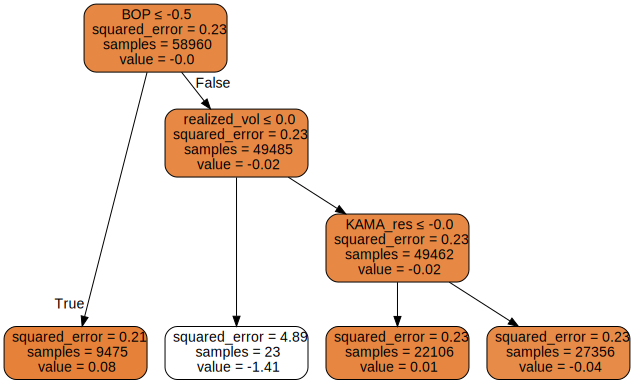

In [ ]:
draw_tree(m, xs_cleaned, size=10, leaves_parallel=True, precision=2)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


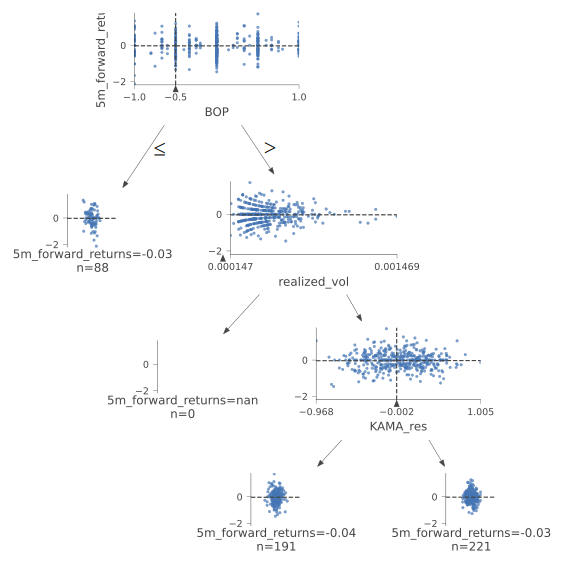

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs_cleaned.iloc[samp_idx], y.iloc[samp_idx], xs_cleaned.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='TD')

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs_cleaned, y);

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(m, xs_cleaned, y)

0.0

In [ ]:
m_rmse(m, valid_xs_cleaned, valid_y)

0.722444

In [ ]:
m.get_n_leaves(), len(xs_cleaned)

(np.int64(50146), 58960)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs_cleaned, y)
m_rmse(m, xs_cleaned, y), m_rmse(m, valid_xs_cleaned, valid_y)

(0.404657, 0.554702)

In [ ]:
m.get_n_leaves()

np.int64(1837)

# 4. Random Forest Model

We transition to a Random Forest Regressor to improve generalization. This section includes:
- Defining a Random Forest function.
- Training the model.
- analyzing the RMSE on the validation set.
- Checking how the error converges as we add more trees (estimators).

In [ ]:
def rf(xs, y, n_estimators=200, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs_cleaned, y);

In [ ]:
m_rmse(m, xs_cleaned, y), m_rmse(m, valid_xs_cleaned, valid_y)

(0.257754, 0.488915)

In [ ]:
y_std = np.std(valid_y)
print(y_std)

0.48623886704444885


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

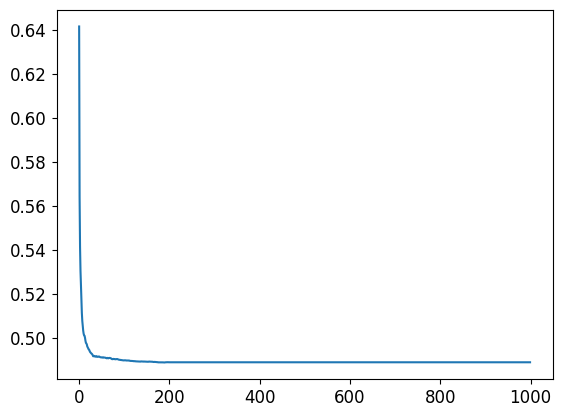

In [ ]:
preds = np.stack([t.predict(valid_xs_cleaned) for t in m.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(1000)]);

In [ ]:
r_mse(m.oob_prediction_, y)

0.445534

In [ ]:
preds.shape

(200, 11970)

In [ ]:
preds_std = preds.std(0)

In [ ]:
preds_std[:5]

array([0.44391408, 0.40991392, 0.4023177 , 0.41147022, 0.4330156 ])

# 5. Feature Importance and Selection

Using the Random Forest model, we calculate feature importance to identify the most predictive signals. We then:
- Filter out low-importance features.
- Analyze redundant features (using clustering and Out-of-Bag scores) to create a more compact and efficient feature set (`xs_final`).

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs_cleaned)
fi[:10]

,cols,imp
73,vol_ratio,0.036645
58,cos_time_cycle,0.036334
60,realized_vol,0.035826
59,sin_time_cycle,0.031042
61,realized_vol_60,0.029607
37,ADX,0.028374
57,KAMA_res,0.024548
42,bandwidth,0.024248
35,MFI,0.023616
47,Dir_Ind_Diff,0.023349


<Axes: ylabel='cols'>

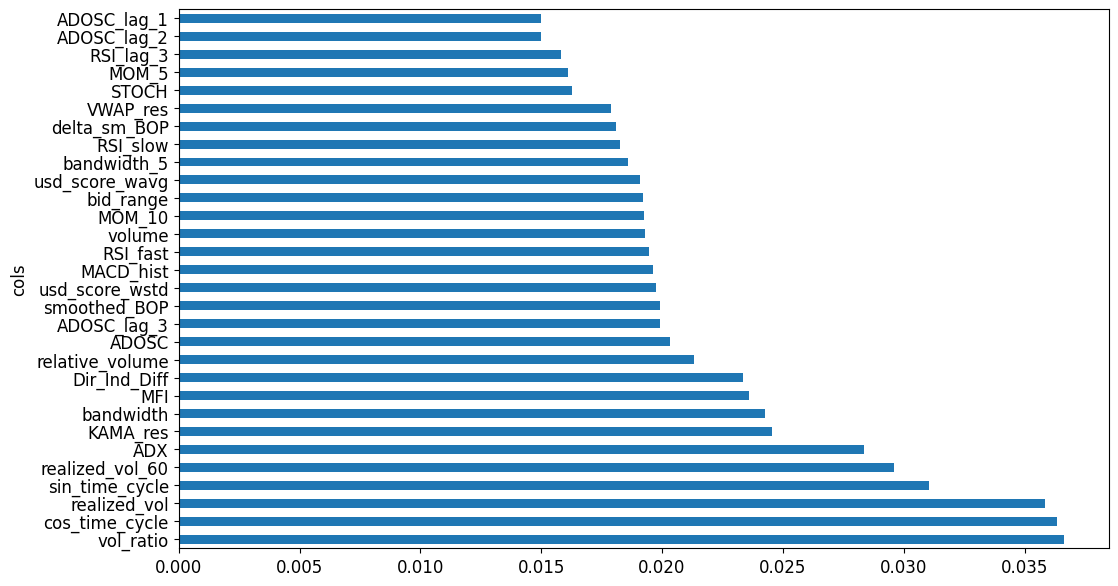

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

In [ ]:
to_keep = fi[fi.imp>0.015].cols
len(to_keep)

29

In [ ]:
xs_imp = xs_cleaned[to_keep]
valid_xs_imp = valid_xs_cleaned[to_keep]

In [ ]:
m = rf(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.260623, 0.491219)

In [ ]:
len(xs_cleaned.columns), len(xs_imp.columns)

(76, 29)

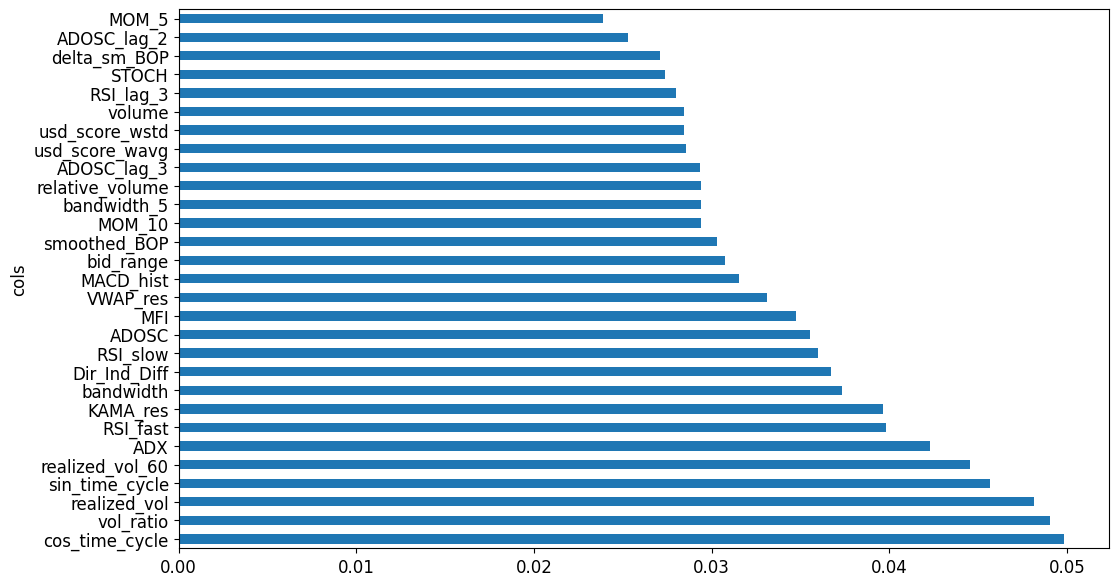

In [ ]:
fi = rf_feat_importance(m, xs_imp)
plot_fi(fi);

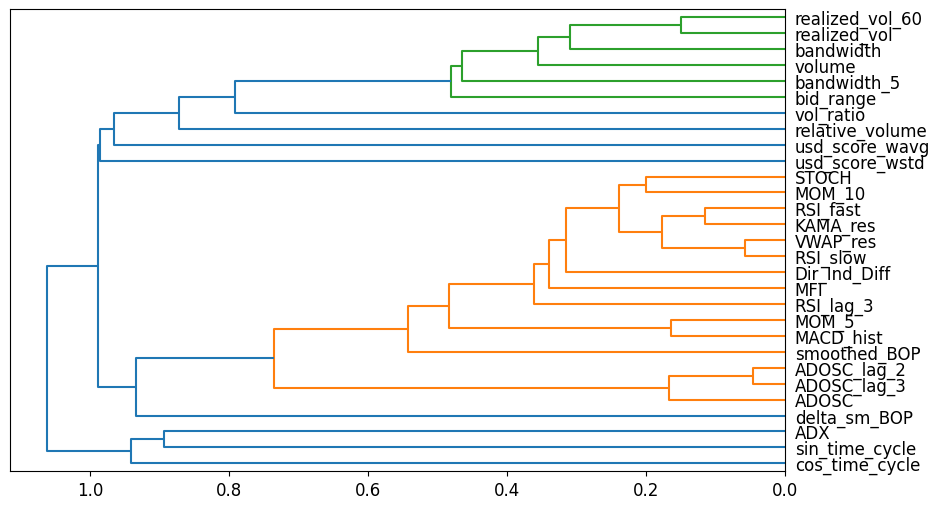

In [ ]:
cluster_columns(xs_imp)

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=200, min_samples_leaf=15,
                              max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [ ]:
get_oob(xs_imp)

0.10744575169827397

In [ ]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'realized_vol_60', 'realized_vol', 'STOCH', 'MOM_10',
    'VWAP_res', 'RSI_slow', 'RSI_fast', 'KAMA_res',
    'MOM_5', 'MACD_hist', 'ADOSC_lag_2', 'ADOSC_lag_3',
    'ADX', 'sin_time_cycle')}

{'realized_vol_60': 0.10037420587924517,
 'realized_vol': 0.10093751515088034,
 'STOCH': 0.10900380109042196,
 'MOM_10': 0.10986199759491688,
 'VWAP_res': 0.10595523604502832,
 'RSI_slow': 0.1038457265235243,
 'RSI_fast': 0.10443288449246246,
 'KAMA_res': 0.10475279434259621,
 'MOM_5': 0.11011429553983376,
 'MACD_hist': 0.10662706087510587,
 'ADOSC_lag_2': 0.10728056173605294,
 'ADOSC_lag_3': 0.10617453555710299,
 'ADX': 0.09975575157038907,
 'sin_time_cycle': 0.09674185594635276}

In [ ]:
to_drop = ['realized_vol_60', 'realized_vol','RSI_fast', 'KAMA_res', 'VWAP_res', 'RSI_slow',
           'ADOSC_lag_2', 'ADOSC_lag_3', 'ADX', 'sin_time_cycle']
get_oob(xs_imp.drop(to_drop, axis=1))

0.05132137891064659

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
save_pickle('data/xs_final.pkl', xs_final)
save_pickle('data/valid_xs_final.pkl', valid_xs_final)

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.291162, 0.489857)

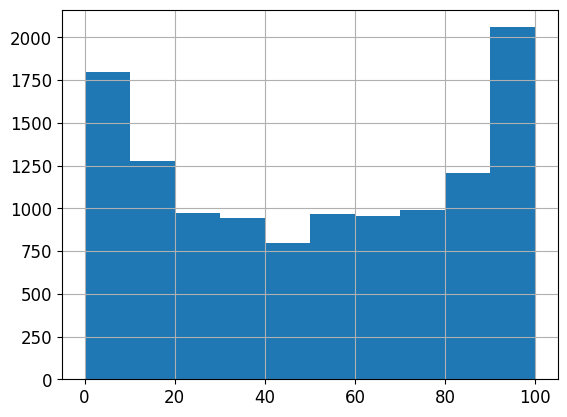

In [ ]:
ax = valid_xs_final['STOCH'].hist()

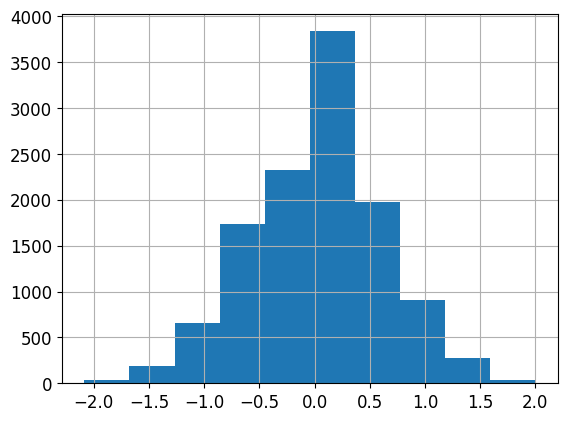

In [ ]:
ax = valid_xs_final['MOM_10'].hist()

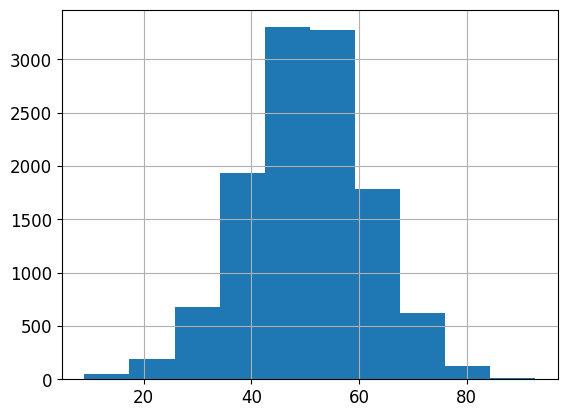

In [ ]:
ax = valid_xs_final['RSI'].hist()

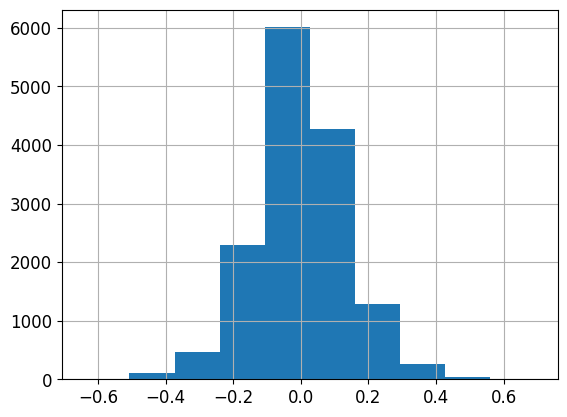

In [ ]:
ax = valid_xs_final['KAMA_res'].hist()

# 6. Model Interpretation

To understand *how* the model makes predictions, we use:
- **Partial Dependence Plots**: To see the marginal effect of specific features.
- **Waterfall Charts**: To break down a specific prediction instance contribution by contribution.
- **Domain Shift Check**: We also check if the model can distinguish between training and validation sets, which would indicate a drift in data distribution.

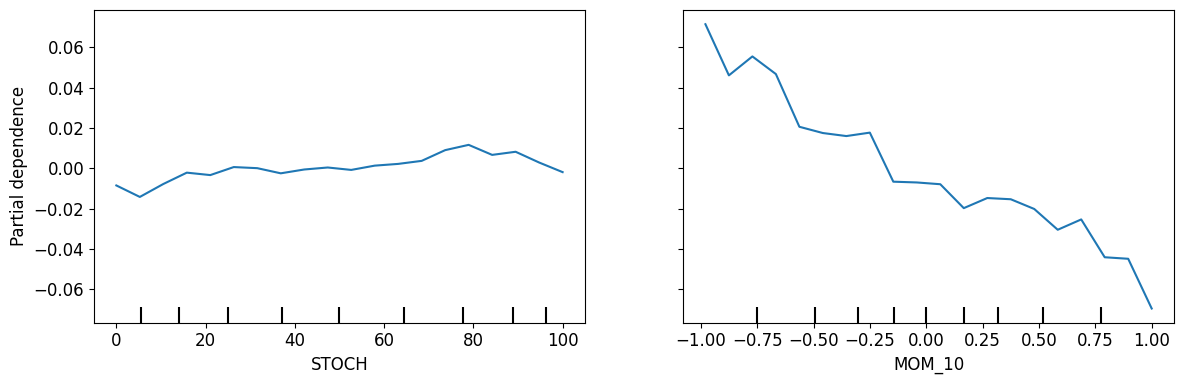

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

PartialDependenceDisplay.from_estimator(
    m,                   # your fitted model
    valid_xs_final,      # your validation features (DataFrame or array)
    ['STOCH', 'MOM_10'],  # features
    grid_resolution=20,
    ax=ax
)
plt.tight_layout()

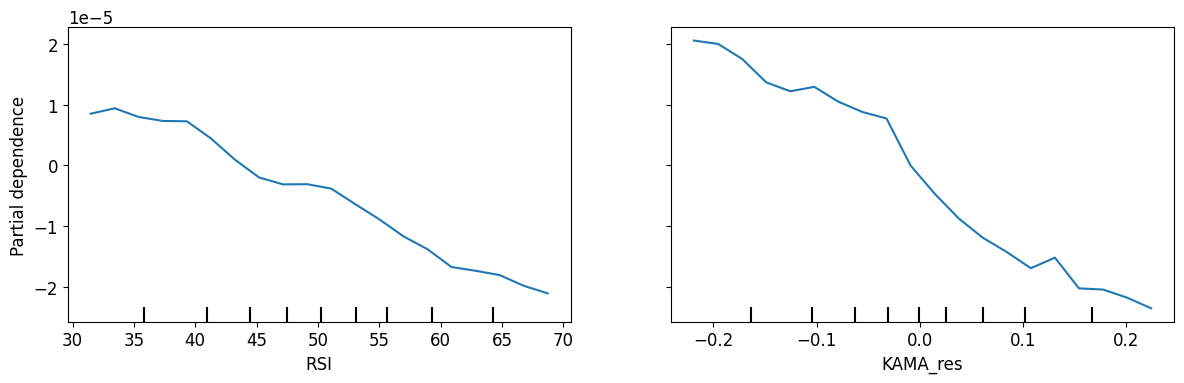

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

PartialDependenceDisplay.from_estimator(
    m,                   # your fitted model
    valid_xs_final,      # your validation features (DataFrame or array)
    ['RSI', 'KAMA_res'],  # features
    grid_resolution=20,
    ax=ax
)
plt.tight_layout()

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
row = valid_xs_final.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([-0.01301056]),
 np.float64(-0.001907812332039923),
 np.float64(-0.011102743071716303))

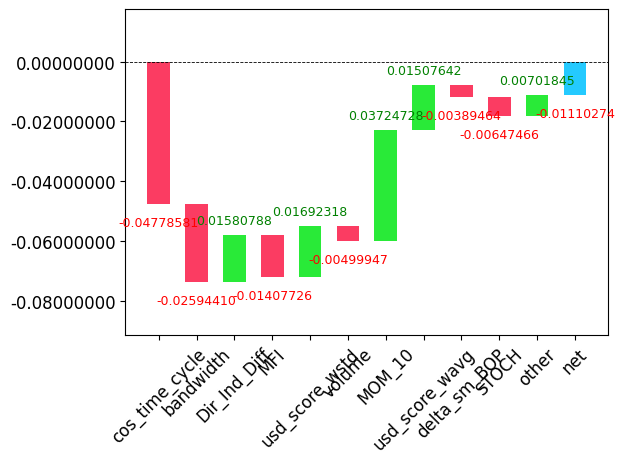

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45,formatting='{:,.8f}');

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
9,bandwidth_5,0.423893
0,cos_time_cycle,0.099607
2,bandwidth,0.054146
1,ADOSC,0.053744
3,Dir_Ind_Diff,0.052770
7,volume,0.047703


In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

c = 'bandwidth_5'
m = rf(xs_final.drop(c,axis=1), y)
print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.489841
bandwidth_5 0.490394


# 7. Neural Network Model

We train a Neural Network using `fastai`'s tabular learner to see if a deep learning approach captures different patterns than the tree-based models. We then create an ensemble by averaging the Neural Network predictions with the Random Forest predictions.

In [ ]:
df_nn = pd.read_csv("data/data.csv",
                 low_memory=False,
                 parse_dates=["timestamp", "minute_utc"],
                 )
df_nn["minute_utc"] = pd.to_datetime(df_nn["minute_utc"], utc=True, errors="coerce")

In [ ]:
df_nn_final = df_nn[list(xs_final.columns) + [dep_var]].copy()
df_nn_final.dropna(subset=[dep_var], inplace=True)

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=40, dep_var=dep_var)

In [ ]:
cont_nn, cat_nn

(['cos_time_cycle',
  'ADOSC',
  'bandwidth',
  'Dir_Ind_Diff',
  'MFI',
  'relative_volume',
  'usd_score_wstd',
  'volume',
  'MOM_10',
  'bandwidth_5',
  'usd_score_wavg',
  'delta_sm_BOP',
  'STOCH',
  'AROON'],
 [])

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]

# Recalculate splits based on the cleaned df_nn_final indices
current_indices = df_nn_final.index
new_train_indices = current_indices[current_indices < 58960].tolist()
new_valid_indices = current_indices[current_indices > 58964].tolist()
updated_splits = (new_train_indices, new_valid_indices)

to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=updated_splits, y_names=dep_var)

In [ ]:
print(f"Unique values in 'volume': {df_nn_final['AROON'].nunique()}")
print(f"Data type of 'volume': {df_nn_final['AROON'].dtype}")

Unique values in 'volume': 49
Data type of 'volume': int64


In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

(-7.1034674644470215, 4.470799446105957)

In [ ]:
learn = tabular_learner(dls, y_range=(-7.5,5), layers=[500, 250],
                        n_out=1, loss_func=F.mse_loss,
                        config=tabular_config(ps=[0.25, 0.25], embed_p=0.25))

SuggestedLRs(valley=0.0003311311302240938)

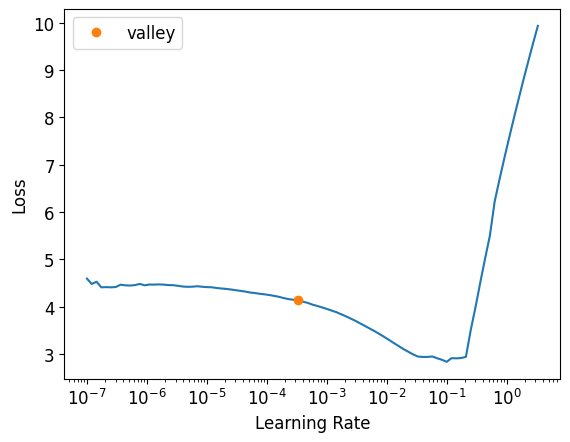

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(50, 5e-4)

epoch,train_loss,valid_loss,time
0,3.618934,1.415293,00:00
1,3.156221,1.221524,00:00
2,2.723441,1.025378,00:00
3,2.259503,0.825756,00:00
4,1.811013,0.652444,00:00
5,1.384137,0.493724,00:00
6,1.045403,0.411479,00:00
7,0.801160,0.305269,00:00
8,0.620387,0.286880,00:00
9,0.495699,0.266917,00:00


In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.487813

In [ ]:
learn.save('nn')

Path('models/nn.pth')

In [ ]:
m = rf(xs_final, y)
rf_preds = m.predict(to_nn.valid.xs[xs_final.columns])
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [ ]:
r_mse(ens_preds, to_nn.valid.y.values)

0.606895

# 8. XGBoost Model with Hyperparameter Tuning

Finally, we implement an XGBoost model, known for its high performance on tabular data. We use **Optuna** to perform Bayesian optimization and find the best hyperparameters (learning rate, depth, regularization, etc.) to minimize RMSE on the validation set. We then retrain the best model and perform a detailed analysis of its residuals and feature correlations.

In [ ]:
!pip install xgboost
!pip install optuna

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

In [ ]:
# 1. Baseline RMSE (Guessing the mean)
baseline_preds = np.ones(len(valid_y)) * valid_y.mean()
baseline_rmse = r_mse(baseline_preds, valid_y)

# 2. Random Forest RMSE (Ensure we use the correct unnormalized validation set)
# Note: 'm' is the trained Random Forest from previous cells
rf_preds_corrected = m.predict(valid_xs_final)
rf_rmse = r_mse(rf_preds_corrected, valid_y)

# 3. Ensemble RMSE
# 'preds' contains the NN predictions from learn.get_preds()
# We average the corrected RF preds and the NN preds
# We assume 'preds' aligns with 'valid_y' (both from validation set)
ens_preds_corrected = (to_np(preds.squeeze()) + rf_preds_corrected) / 2
ens_rmse = r_mse(ens_preds_corrected, valid_y)

# Calculate Edge
rf_edge = baseline_rmse - rf_rmse
ens_edge = baseline_rmse - ens_rmse

print(f"Baseline RMSE: {baseline_rmse:.6f}")
print(f"Random Forest RMSE: {rf_rmse:.6f} (Edge: {rf_edge:.6f})")
print(f"Ensemble RMSE: {ens_rmse:.6f} (Edge: {ens_edge:.6f})")

Baseline RMSE: 0.486239
Random Forest RMSE: 0.490175 (Edge: -0.003936)
Ensemble RMSE: 0.487644 (Edge: -0.001405)


In [ ]:
import numpy as np
import optuna


# Ensure no NaNs/Infs in target
# Train set cleaning
mask_train = ~y.isna() & ~np.isinf(y)
if (~mask_train).any():
    print(f"Dropping {(~mask_train).sum()} rows from train with NaN/Inf targets")
    xs_final = xs_final[mask_train]
    y = y[mask_train]

# Validation set cleaning
mask_valid = ~valid_y.isna() & ~np.isinf(valid_y)
if (~mask_valid).any():
    print(f"Dropping {(~mask_valid).sum()} rows from valid with NaN/Inf targets")
    valid_xs_final = valid_xs_final[mask_valid]
    valid_y = valid_y[mask_valid]

def objective(trial):
    params = {
        # Keep this high and let early stopping choose effective complexity
        "n_estimators": 6000,
        "early_stopping_rounds": 50,  # Moved here: parameter for constructor

        # Core knobs
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),  # min_split_loss

        # Sampling (regularization via randomness)
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),

        # L1/L2 regularization
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-9, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 100.0, log=True),

        # Plumbing
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": 0,
    }

    model = XGBRegressor(**params)

    model.fit(
        xs_final,
        y,
        eval_set=[(valid_xs_final, valid_y)],
        # early_stopping_rounds removed from here
        verbose=False,
    )

    preds = model.predict(valid_xs_final)
    score = r_mse(valid_y, preds)

    # Useful for debugging / analyzing runs
    if getattr(model, "best_iteration", None) is not None:
        trial.set_user_attr("best_iteration", int(model.best_iteration))

    return score

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=7),
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)
print("Best best_iteration:", study.best_trial.user_attrs.get("best_iteration"))

[I 2025-12-29 02:12:08,828] A new study created in memory with name: no-name-ad981e81-c128-4898-a097-49bb9dab1e6a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-29 02:12:09,058] Trial 0 finished with value: 0.486214 and parameters: {'learning_rate': 0.001498261648108178, 'max_depth': 9, 'min_child_weight': 0.28002836414010834, 'gamma': 7.234651778309412, 'subsample': 0.9889947559983013, 'colsample_bytree': 0.7692479352052168, 'reg_alpha': 0.00010261353203244582, 'reg_lambda': 3.7705878770493985e-06}. Best is trial 0 with value: 0.486214.
[I 2025-12-29 02:12:09,872] Trial 1 finished with value: 0.485602 and parameters: {'learning_rate': 0.004146542730827615, 'max_depth': 6, 'min_child_weight': 1.7464597905446306, 'gamma': 8.037390361043755, 'subsample': 0.6904705665742692, 'colsample_bytree': 0.5329681734529526, 'reg_alpha': 7.611250105457495e-07, 'reg_lambda': 18.912468677325844}. Best is trial 1 with value: 0.485602.
[I 2025-12-29 02:12:10,801] Trial 2 finished with value: 0.485621 and parameters: {'learning_rate': 0.0030974627996148197, 'max_depth': 6, 'min_child_weight': 11.856022180852209, 'gamma': 0.24899227550348013, 'subsampl

In [ ]:
# Calculate XGBoost Edge
best_xgb_rmse = study.best_value
xgb_edge = baseline_rmse - best_xgb_rmse

print(f"Baseline RMSE: {baseline_rmse:.6f}")
print(f"Best XGBoost RMSE: {best_xgb_rmse:.6f}")
print(f"XGBoost Edge: {xgb_edge:.6f}")

Baseline RMSE: 0.486239
Best XGBoost RMSE: 0.485054
XGBoost Edge: 0.001185


## Retrain Best XGBoost

Retrain the XGBoost model on the training set using the best hyperparameters identified by the Optuna study to establish a baseline for analysis.


In [ ]:
best_params = study.best_params.copy()

# Add fixed params
best_params.update({
    "n_estimators": 6000,
    "early_stopping_rounds": 50,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": -1,
    "verbosity": 0,
})

model = XGBRegressor(**best_params)

model.fit(
    xs_final,
    y,
    eval_set=[(valid_xs_final, valid_y)],
    verbose=False,
)

preds_xgb = model.predict(valid_xs_final)
rmse = r_mse(preds_xgb, valid_y)
print(f"Retrained XGBoost RMSE: {rmse}")

Retrained XGBoost RMSE: 0.485054


## Analyze Feature Importance

Generate and visualize a feature importance plot (using gain) from the retrained XGBoost model to identify the most influential predictors.


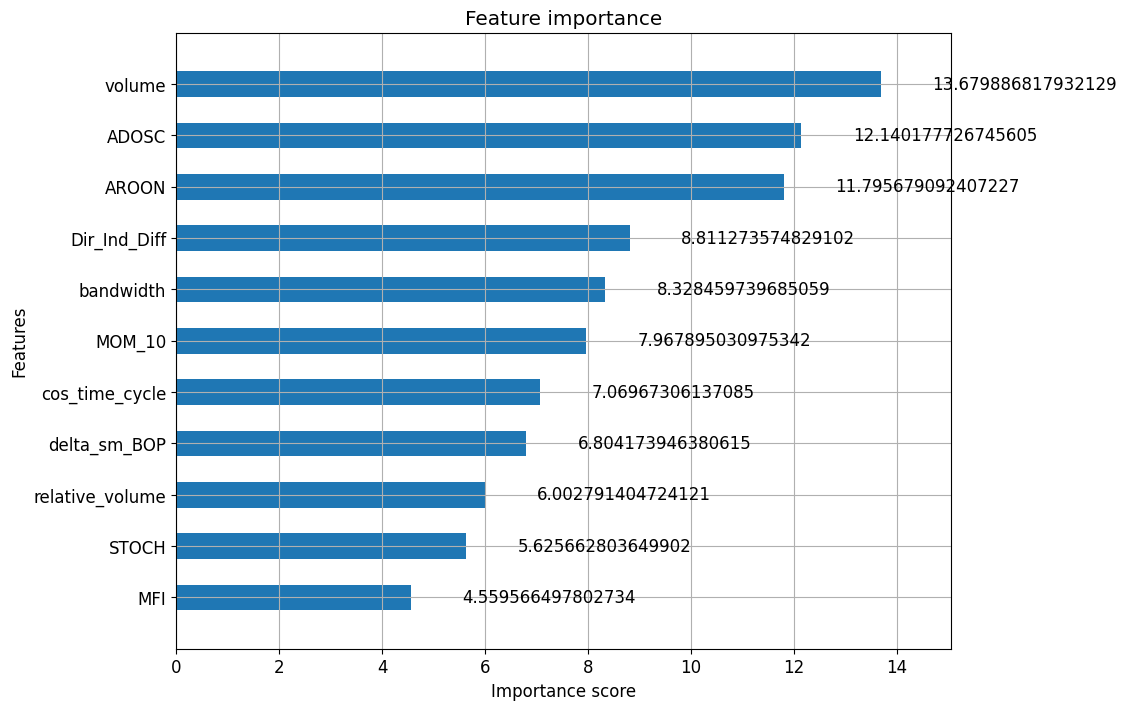

            Feature       Gain
6            volume  13.679887
1             ADOSC  12.140178
10            AROON  11.795679
3      Dir_Ind_Diff   8.811274
2         bandwidth   8.328460
7            MOM_10   7.967895
0    cos_time_cycle   7.069673
8      delta_sm_BOP   6.804174
5   relative_volume   6.002791
9             STOCH   5.625663


In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, importance_type='gain', max_num_features=20, height=0.5, ax=ax)
plt.show()

# Extract and display feature importance as DataFrame
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Gain'])
importance_df = importance_df.sort_values(by='Gain', ascending=False)
print(importance_df.head(10))

## Analyze Feature Correlations

Compute and plot a correlation heatmap between the top influential features and the target variable to detect linear relationships and redundancy.


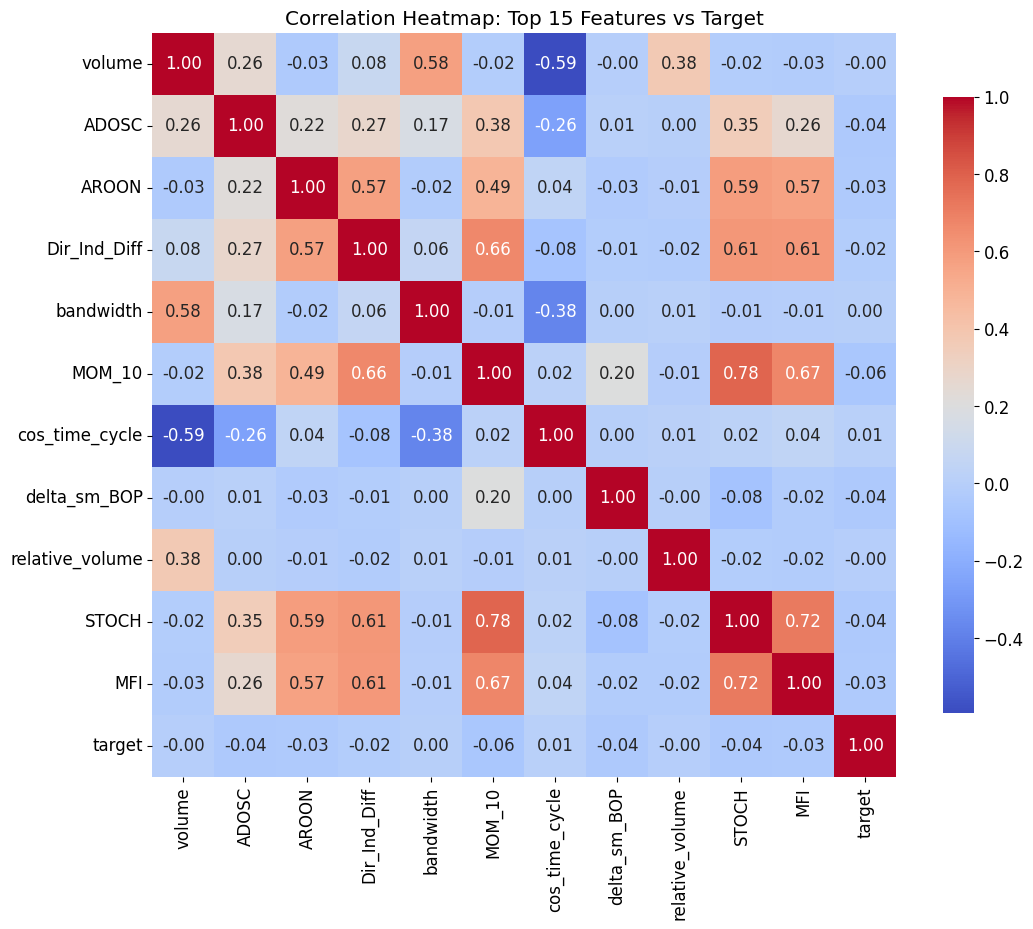

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extract top 15 feature names
top_features = importance_df['Feature'].head(15).tolist()

# 2. Create temporary DataFrame with top features and target
# We use .copy() to avoid SettingWithCopy warnings if xs_final is a view
temp_df = xs_final[top_features].copy()
temp_df['target'] = y

# 3. Calculate correlation matrix
corr_matrix = temp_df.corr()

# 4. Visualize correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap: Top 15 Features vs Target")
plt.show()

## Analyze Target Autocorrelation

Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the target variable to assess the potential value of adding lag-based features.


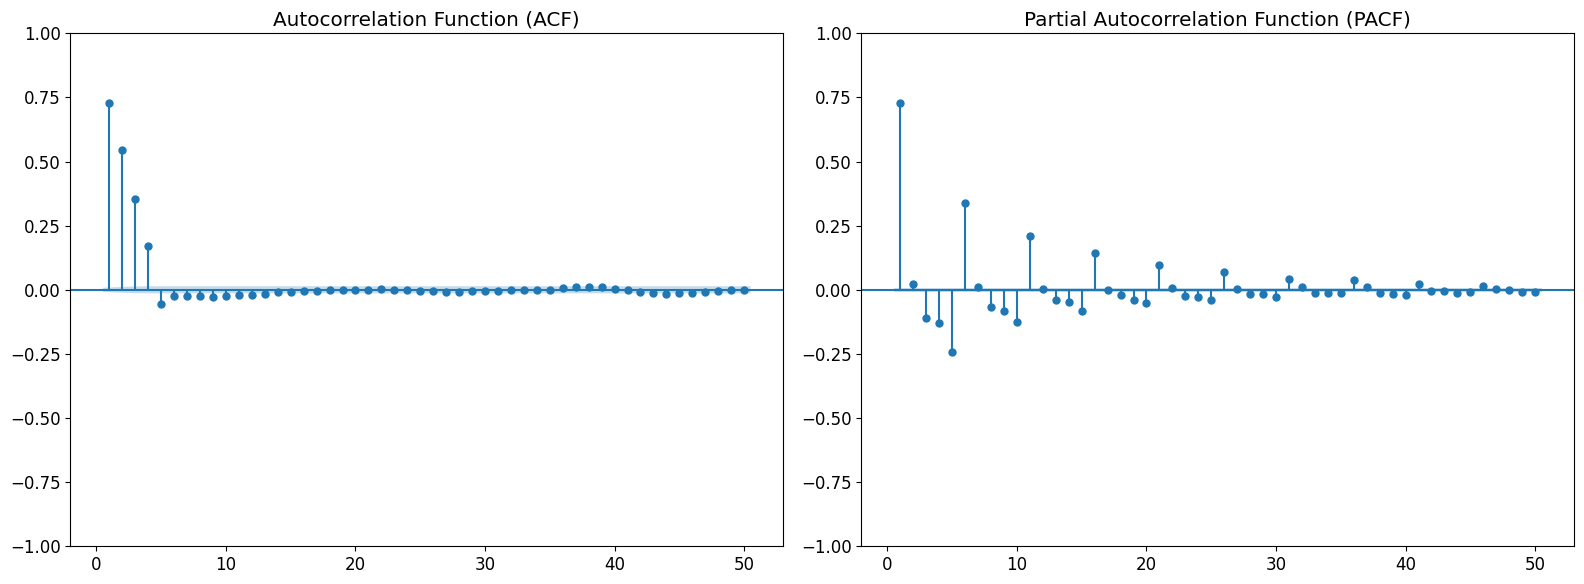

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(y, lags=50, zero=False, ax=axes[0], title='Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(y, lags=50, zero=False, ax=axes[1], title='Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Analyze Model Residuals

Calculate residuals on the validation set and visualize them to identify patterns.


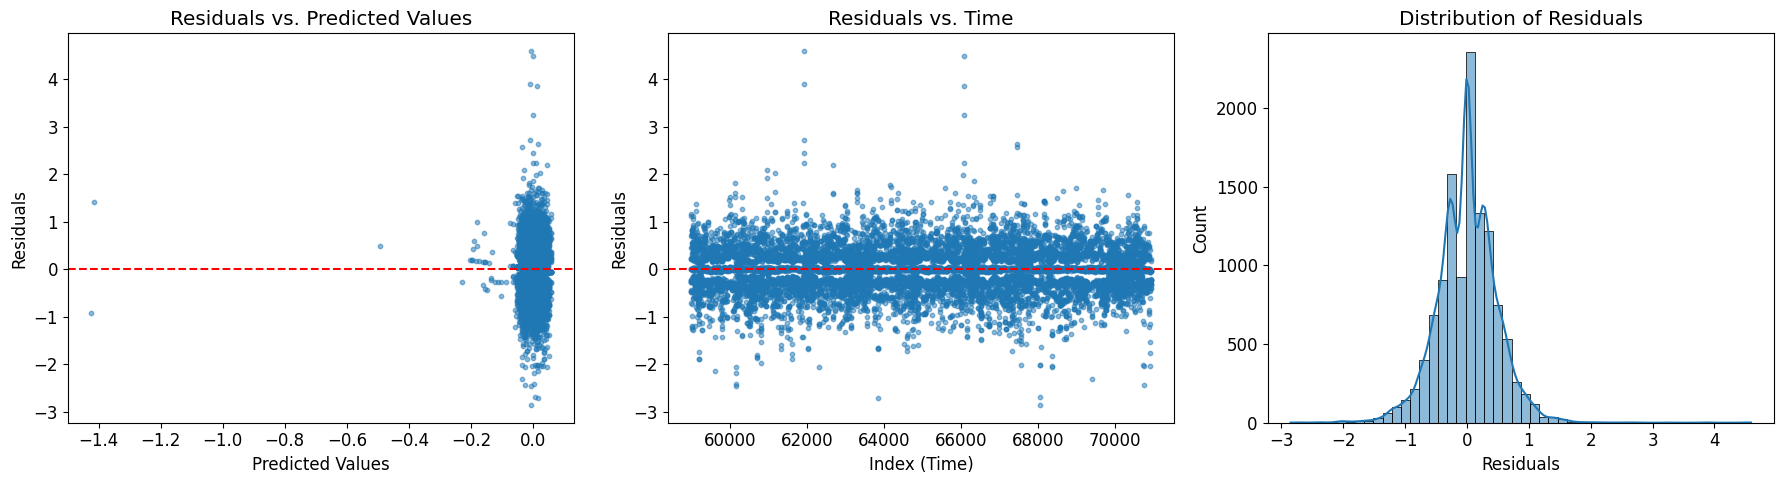

Residuals Statistics:
count    11970.000000
mean         0.000922
std          0.485072
min         -2.852051
25%         -0.281840
50%          0.005814
75%          0.292671
max          4.590367
Name: 5m_forward_returns, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate residuals
residuals = valid_y - preds_xgb

# 2. Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 3. Residuals vs Predicted Values
axes[0].scatter(preds_xgb, residuals, alpha=0.5, s=10)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs. Predicted Values')

# 4. Residuals vs Time (Index)
axes[1].scatter(valid_y.index, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Index (Time)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs. Time')

# 5. Histogram of Residuals
sns.histplot(residuals, kde=True, bins=50, ax=axes[2])
axes[2].set_xlabel('Residuals')
axes[2].set_title('Distribution of Residuals')

# 6. Display the figure
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("Residuals Statistics:")
print(residuals.describe())

## Walkforward Validation

Use `TimeSeriesSplit` to verify edge of best XGBoost model on test set.



In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# 4. Walk-Forward Validation Loop
tscv = TimeSeriesSplit(n_splits=5)

params_wfv = study.best_params.copy()
params_wfv.update({
    "n_estimators": 2000, # Reduced slightly for speed during WFV loop
    "early_stopping_rounds": 50,
    "tree_method": "hist",
    "n_jobs": -1,
    "verbosity": 0
})

rmse_scores = []

print("Starting Walk-Forward Validation...")

for fold, (train_index, test_index) in enumerate(tscv.split(xs_final)):
    # Split data
    X_train, X_test = xs_final.iloc[train_index], xs_final.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Init and Fit
    model_wfv = XGBRegressor(**params_wfv)
    model_wfv.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # Predict
    preds = model_wfv.predict(X_test)
    score = r_mse(preds, y_test)
    rmse_scores.append(score)

    print(f"Fold {fold+1} RMSE: {score:.6f} (Train Size: {len(X_train)}, Test Size: {len(X_test)})")

print(f"\nAverage WFV RMSE: {np.mean(rmse_scores):.6f}")
print(f"Std Dev WFV RMSE: {np.std(rmse_scores):.6f}")

Starting Walk-Forward Validation...
Fold 1 RMSE: 0.473061 (Train Size: 9830, Test Size: 9826)
Fold 2 RMSE: 0.476651 (Train Size: 19656, Test Size: 9826)
Fold 3 RMSE: 0.459674 (Train Size: 29482, Test Size: 9826)
Fold 4 RMSE: 0.490059 (Train Size: 39308, Test Size: 9826)
Fold 5 RMSE: 0.481493 (Train Size: 49134, Test Size: 9826)

Average WFV RMSE: 0.476188
Std Dev WFV RMSE: 0.010032
